In [1]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import r2_score, accuracy_score

In [2]:
# use dice similarity
from sklearn.metrics.pairwise import cosine_similarity

''' 
Takes a fingerprint (might be non-binary), calculate the maximum generalized Dice similarity between it and a set of fingerprints.
'''
def dice_sim(f, set_of_f):
    f = np.array(f)
    set_of_f = np.array(set_of_f) 

    min_count = np.minimum(f, set_of_f).sum(axis=1) * 2
    sum_count = f.sum() + set_of_f.sum(axis=1)
    sum_count[sum_count == 0] = 1
    return np.max(min_count / sum_count)

In [3]:
def eval(Y, rejected, lower, higher):
    true_reject = np.sum((lower < Y) & (Y < higher))
    if len(rejected) == 0:
        fdp = 0
        pcer = 0
        power = 0
    else:
        fdp = np.sum((lower >= Y[rejected]) | (Y[rejected] >= higher)) / len(rejected)
        pcer = np.sum((lower >= Y[rejected]) | (Y[rejected] >= higher)) / len(Y)
        power = np.sum((lower < Y[rejected]) & (Y[rejected] < higher)) / true_reject if true_reject != 0 else 0
    return fdp, pcer, power

In [25]:
from sklearn.model_selection import train_test_split

dataset_name = 'TDI'
dataset_path = f'data\\{dataset_name}_training_disguised.csv'

dataset = pd.read_csv(dataset_path)

# dataset = dataset.sample(frac = 0.1)

total_Y = dataset['Act'].to_numpy()
total_X = dataset.drop(columns=['MOLECULE', 'Act']).to_numpy()

Xtc, Xtest, Ytc, Ytest = train_test_split(total_X, total_Y, test_size=0.3, shuffle=True) # tc: train and calib
# use this test set (Xtest, Ytest), for both methods for a fair comparison

In [26]:
len(dataset)

4165

In [21]:
# dataset-specific threshold
if dataset_name == 'NK1':
    threshold = 6.5  # 10%
if dataset_name == 'PGP':
    threshold = -0.3 # 15%
if dataset_name == 'LOGD':
    threshold = 1.5  # 13%
if dataset_name == '3A4':
    threshold = 4.35 # 60%
if dataset_name == 'CB1':
    threshold = 6.5  # 32%
if dataset_name == 'DPP4':
    threshold = 6    # 35%
if dataset_name == 'HIVINT':
    threshold = 6    # 27%
if dataset_name == 'HIVPROT':
    threshold = 4.5  # 6%
if dataset_name == 'METAB':
    threshold = 40   # 47%
if dataset_name == 'OX1':
    threshold = 5    # 20%
if dataset_name == 'OX2':
    threshold = 6    # 23%
if dataset_name == 'PPB':
    threshold = 1    # 20%
if dataset_name == 'RAT_F':
    threshold = 0.3  # 8%
if dataset_name == 'TDI':
    threshold = 0    # 24%
if dataset_name == 'THROMBIN':
    threshold = 6    # 37%

In [ ]:
fig, axs = plt.subplots(figsize=(8, 6))
axs.hist(dataset['Act'], bins=100, alpha=0.5)
axs.axvline(threshold, color='red', linestyle='-.', alpha=0.5)
axs.text(threshold - 0.3, 100, f"{100 * (len(dataset[dataset['Act'] <= threshold]) / len(dataset)):.2f}%")
axs.set_xlabel("activity")
axs.set_ylabel("number")
fig.suptitle(f"{dataset_name} dataset distribution and threshold")
plt.show()

len(dataset)

In [10]:
len(dataset[dataset['Act'] <= threshold]) / len(dataset)

0.04361370716510903

In [11]:
RMSE_df = pd.read_csv(f"rmse\\rmse_{dataset_name}.csv").drop(columns=['Unnamed: 0'])

# since for different runs the data split is not the same, using old RMSE_df is in fact not valid. However, otherwise the computational cost will be too high since accumulating the RMSE is slow.

In [ ]:
# perform sheridans method: first get data to generate error curve

import numpy as np
from tqdm import tqdm
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from multiprocessing import Pool
import math

def getrmse():
    Xtrain, Xcalib, Ytrain, Ycalib = train_test_split(Xtc, Ytc, train_size=0.3, shuffle=True)
    rf = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt')
    rf.fit(Xtrain, Ytrain)

    Ypred = rf.predict(Xcalib)
    all_Ypred = np.column_stack([tree.predict(Xcalib) for tree in rf.estimators_])
    Ypredvar = np.var(all_Ypred, axis=1)
    RMSE = np.absolute(Ycalib - Ypred)
    sim_nearest = np.array([dice_sim(x, Xtrain) for x in tqdm(Xcalib)])
    # sim_nearest = dice_sim(Xcalib, Xtrain)

    RMSE_tmp_df = pd.DataFrame({"dice": sim_nearest, "pred": Ypred, "var": Ypredvar, "RMSE": RMSE})
    return RMSE_tmp_df

# ensure each rmse dataset has size > 50000
REPEAT_RMSE = math.ceil(50000 / (0.7 * len(Xtc)))
print(REPEAT_RMSE)

results = []
for k in range(REPEAT_RMSE):
    results.append(getrmse())

RMSE_df = pd.concat(results, ignore_index=True)

RMSE_df.to_csv(f"rmse\\rmse_{dataset_name}.csv")

In [11]:
RMSE_df

,dice,pred,var,RMSE
0,0.920918,8.967307,0.761923,0.238593
1,0.866712,8.376136,1.546494,1.299864
2,0.831518,6.634405,1.751602,2.273705
3,0.839475,7.077008,1.508131,0.794492
4,0.932540,8.209099,2.250663,1.558701
...,...,...,...,...
50363,0.946032,6.584725,1.008745,0.551875
50364,0.881935,7.283153,1.427193,0.307247
50365,0.958372,8.865145,0.812721,0.451955
50366,0.893277,6.685591,1.460129,1.924491


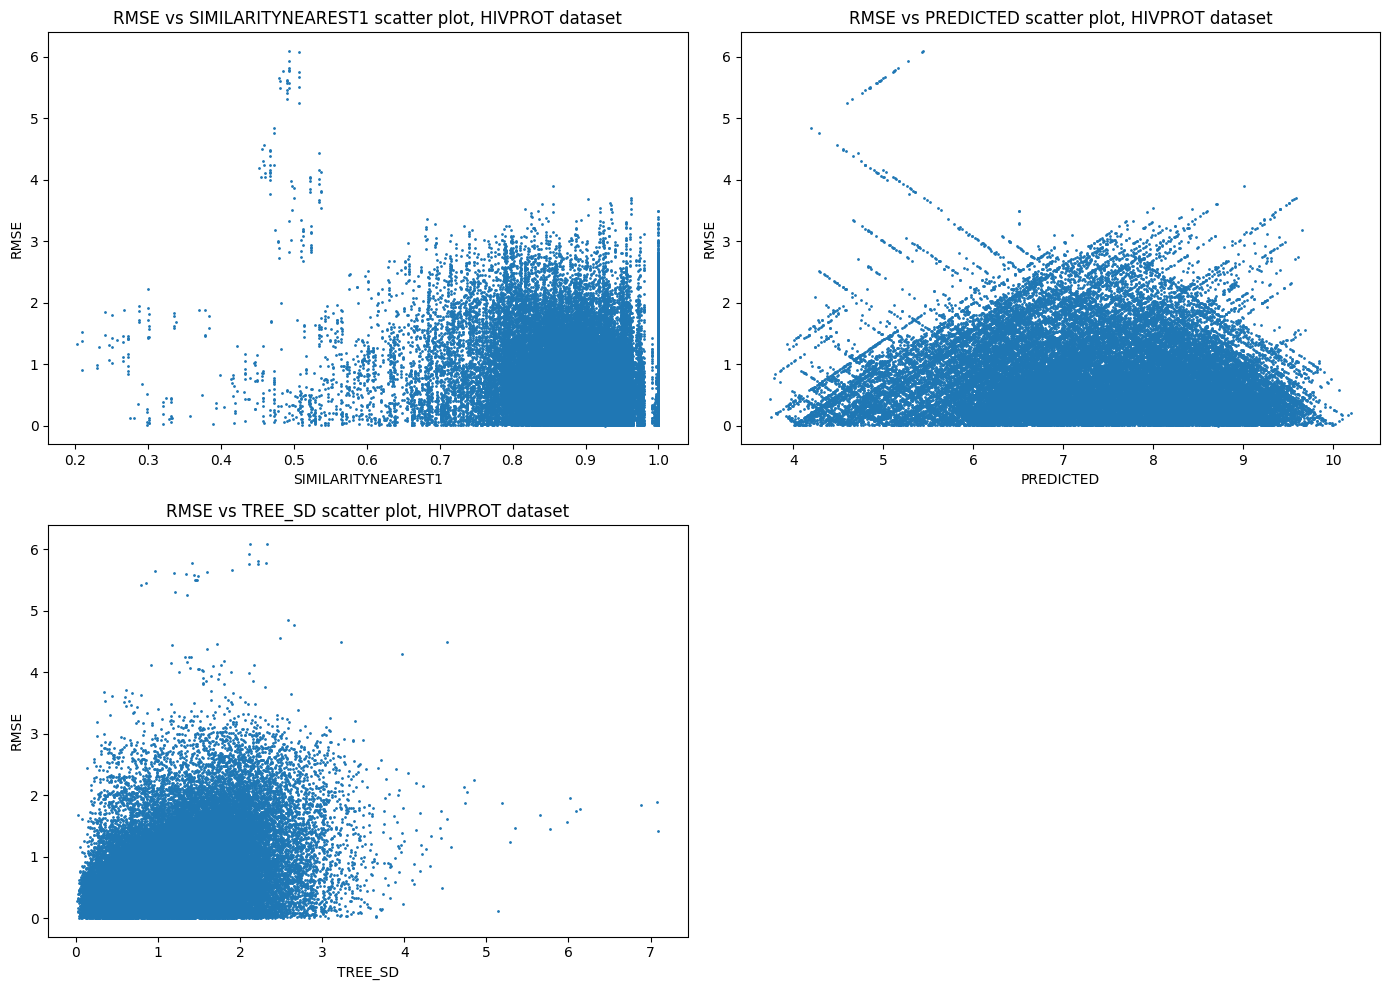

In [12]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(14, 10))

axs[0][0].scatter(RMSE_df['dice'], RMSE_df['RMSE'], s=1)
axs[0][0].set_title(f"RMSE vs SIMILARITYNEAREST1 scatter plot, {dataset_name} dataset")
axs[0][0].set_xlabel("SIMILARITYNEAREST1")
axs[0][0].set_ylabel("RMSE")

axs[0][1].scatter(RMSE_df['pred'], RMSE_df['RMSE'], s=1)
axs[0][1].set_title(f"RMSE vs PREDICTED scatter plot, {dataset_name} dataset")
axs[0][1].set_xlabel("PREDICTED")
axs[0][1].set_ylabel("RMSE")

axs[1][0].scatter(RMSE_df['var'], RMSE_df['RMSE'], s=1)
axs[1][0].set_title(f"RMSE vs TREE_SD scatter plot, {dataset_name} dataset")
axs[1][0].set_xlabel("TREE_SD")
axs[1][0].set_ylabel("RMSE")

fig.delaxes(axs[1][1])
fig.tight_layout()
plt.show()

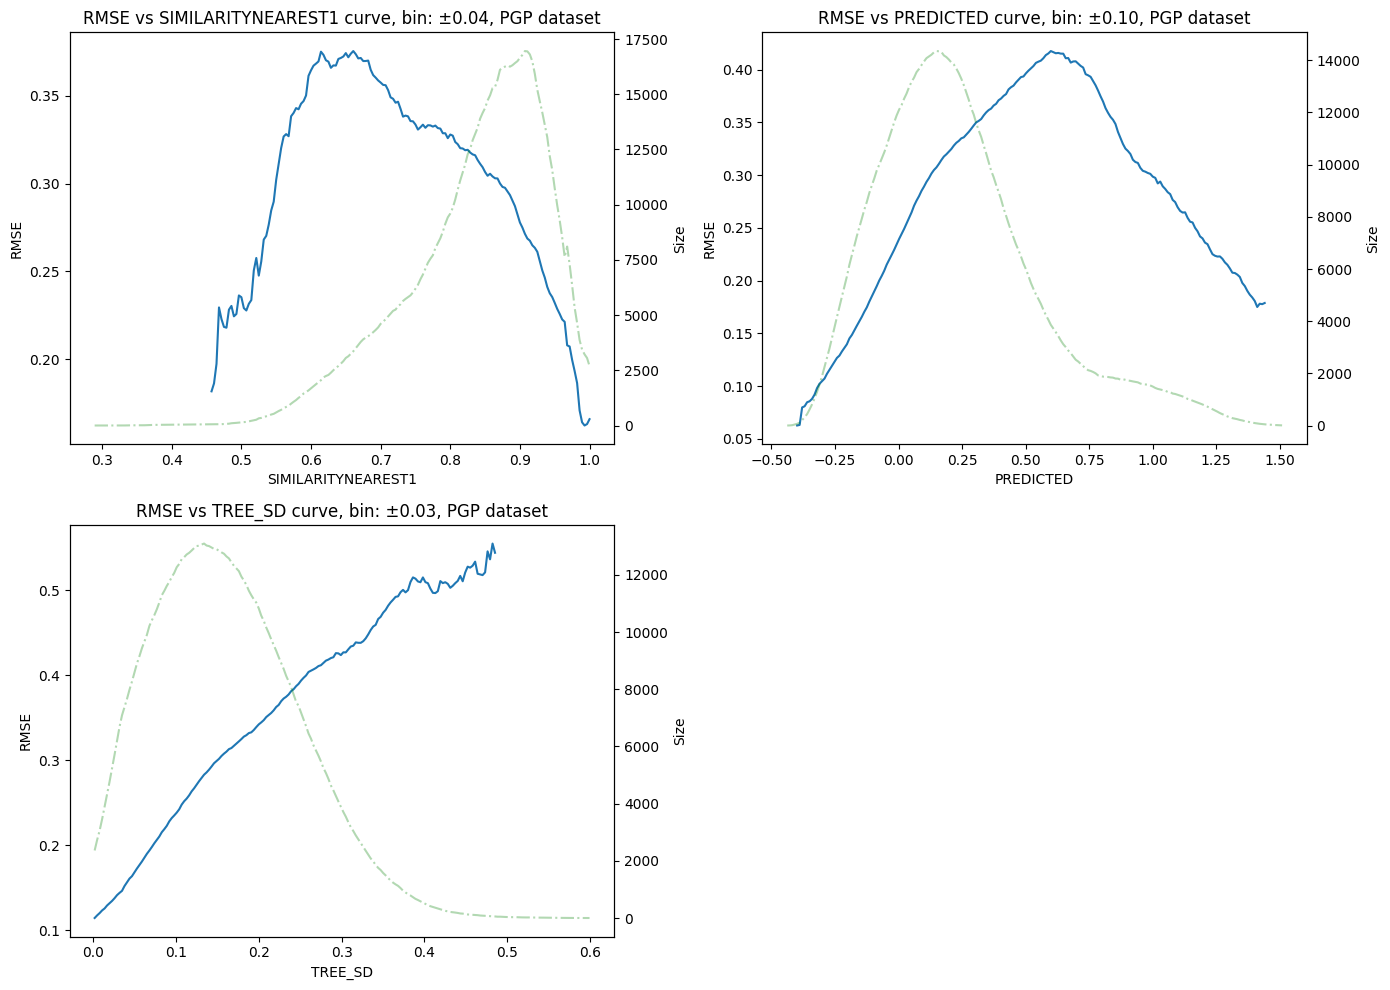

In [11]:
# the two similarities are similar. We will use dice
# now, smoothen it (using bins) and then create an error curve
# bin size: +- 0.05

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(14, 10))

xlist = np.linspace(RMSE_df["dice"].min(), RMSE_df["dice"].max(), 200) # sim
ylist = []
sizelist = []
binsize = (RMSE_df["dice"].max() - RMSE_df["dice"].min()) / 20
for x in xlist:
    low, high = x - binsize, x + binsize
    filtered_RMSE_df = RMSE_df[(low <= RMSE_df["dice"]) & (RMSE_df["dice"] <= high)]
    y_avg = filtered_RMSE_df["RMSE"].mean()
    ylist.append(y_avg)
    sizelist.append(len(filtered_RMSE_df))
ylist = np.array(ylist)
sizelist = np.array(sizelist)

axs[0][0].plot(xlist[sizelist > 50], ylist[sizelist > 50], label='RMSE')
axs[0][0].set_ylabel("RMSE")
axs[0][0].set_xlabel("SIMILARITYNEAREST1")
axs[0][0].set_title(f"RMSE vs SIMILARITYNEAREST1 curve, bin: ±{binsize:.2f}, {dataset_name} dataset")
axs2 = axs[0][0].twinx()
axs2.plot(xlist, sizelist, linestyle='-.', color='green', alpha=0.3, label='values in bin')
axs2.set_ylabel("Size")

xlist = np.linspace(RMSE_df["pred"].min(), RMSE_df["pred"].max(), 200) # sim
ylist = []
sizelist = []
binsize = (RMSE_df["pred"].max() - RMSE_df["pred"].min()) / 20
for x in xlist:
    low, high = x - binsize, x + binsize
    filtered_RMSE_df = RMSE_df[(low <= RMSE_df["pred"]) & (RMSE_df["pred"] <= high)]
    y_avg = filtered_RMSE_df["RMSE"].mean()
    ylist.append(y_avg)
    sizelist.append(len(filtered_RMSE_df))
ylist = np.array(ylist)
sizelist = np.array(sizelist)

axs[0][1].plot(xlist[sizelist > 50], ylist[sizelist > 50], label='RMSE')
axs[0][1].set_ylabel("RMSE")
axs[0][1].set_xlabel("PREDICTED")
axs[0][1].set_title(f"RMSE vs PREDICTED curve, bin: ±{binsize:.2f}, {dataset_name} dataset")
axs2 = axs[0][1].twinx()
axs2.plot(xlist, sizelist, linestyle='-.', color='green', alpha=0.3, label='values in bin')
axs2.set_ylabel("Size")

xlist = np.linspace(RMSE_df["var"].min(), RMSE_df["var"].max(), 200) # sim
ylist = []
sizelist = []
binsize = (RMSE_df["var"].max() - RMSE_df["var"].min()) / 20
for x in xlist:
    low, high = x - binsize, x + binsize
    filtered_RMSE_df = RMSE_df[(low <= RMSE_df["var"]) & (RMSE_df["var"] <= high)]
    y_avg = filtered_RMSE_df["RMSE"].mean()
    ylist.append(y_avg)
    sizelist.append(len(filtered_RMSE_df))
ylist = np.array(ylist)
sizelist = np.array(sizelist)

axs[1][0].plot(xlist[sizelist > 50], ylist[sizelist > 50], label='RMSE')
axs[1][0].set_ylabel("RMSE")
axs[1][0].set_xlabel("TREE_SD")
axs[1][0].set_title(f"RMSE vs TREE_SD curve, bin: ±{binsize:.2f}, {dataset_name} dataset")
axs2 = axs[1][0].twinx()
axs2.plot(xlist, sizelist, linestyle='-.', color='green', alpha=0.3, label='values in bin')
axs2.set_ylabel("Size")

fig.delaxes(axs[1][1])
fig.tight_layout()
plt.show()

In [6]:
# now, need to make this a decision-making procedure
# assume that the prediction region we build is (y_pred + \epsilon * RMSE_pred, +inf). \epsilon is a free (tradeoff) coefficient.
# later, pick \epsilon according to normal distribution quantiles

from tqdm import tqdm

Xtrain, _, Ytrain, _ = train_test_split(Xtc, Ytc, train_size=0.3, shuffle=True)
sim_test = np.array([dice_sim(x, Xtrain) for x in tqdm(Xtest)])

rf = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt')
rf.fit(Xtrain, Ytrain)
Ypred_test = rf.predict(Xtest)

allYpred_test = np.column_stack([tree.predict(Xtest) for tree in rf.estimators_])
var_test = np.var(allYpred_test, axis=1)

100%|██████████| 964/964 [00:16<00:00, 57.30it/s]


##### Sheridan et al. (2004)

In [8]:
# using only 1 bin
rmse_test = []
for s in sim_test:
    # using a fixed 0.05 binsize
    filtered_RMSE_df = RMSE_df[(s - 0.05 <= RMSE_df["dice"]) & (RMSE_df["dice"] <= s + 0.05)]
    rmse = filtered_RMSE_df["RMSE"].mean()
    rmse_test.append(rmse)
rmse_test = np.array(rmse_test)

In [9]:
from scipy.stats import norm
from sklearn.metrics import r2_score

# miscoverage: 0.01 to 0.5
misc = np.linspace(0.01, 0.99, 200)
alphas = 1 - misc  # confidence level

eps = [norm.ppf(alpha) for alpha in alphas] # positive
fdps_04, pcers_04, powers_04 = np.zeros(200), np.zeros(200), np.zeros(200)

itr = 100
for k in tqdm(range(itr)):
    # repartition data and fit
    rf = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt')
    Xtrain, Xcalib, Ytrain, Ycalib = train_test_split(Xtc, Ytc, train_size=0.3, shuffle=True)
    rf.fit(Xtrain, Ytrain)
    Ypred_test = rf.predict(Xtest)

    for i, ep in enumerate(eps):
        # build (-inf, Ypred + ep * rmse), alpha% confidence interval
        sheridan_04 = [j for j in range(len(Ypred_test)) if Ypred_test[j] + ep * rmse_test[j] <= threshold]
        fdp, pcer, power = eval(Ytest, sheridan_04, -100, threshold)
        fdps_04[i] += fdp / itr
        pcers_04[i] += pcer / itr
        powers_04[i] += power / itr

100%|██████████| 100/100 [01:38<00:00,  1.02it/s]


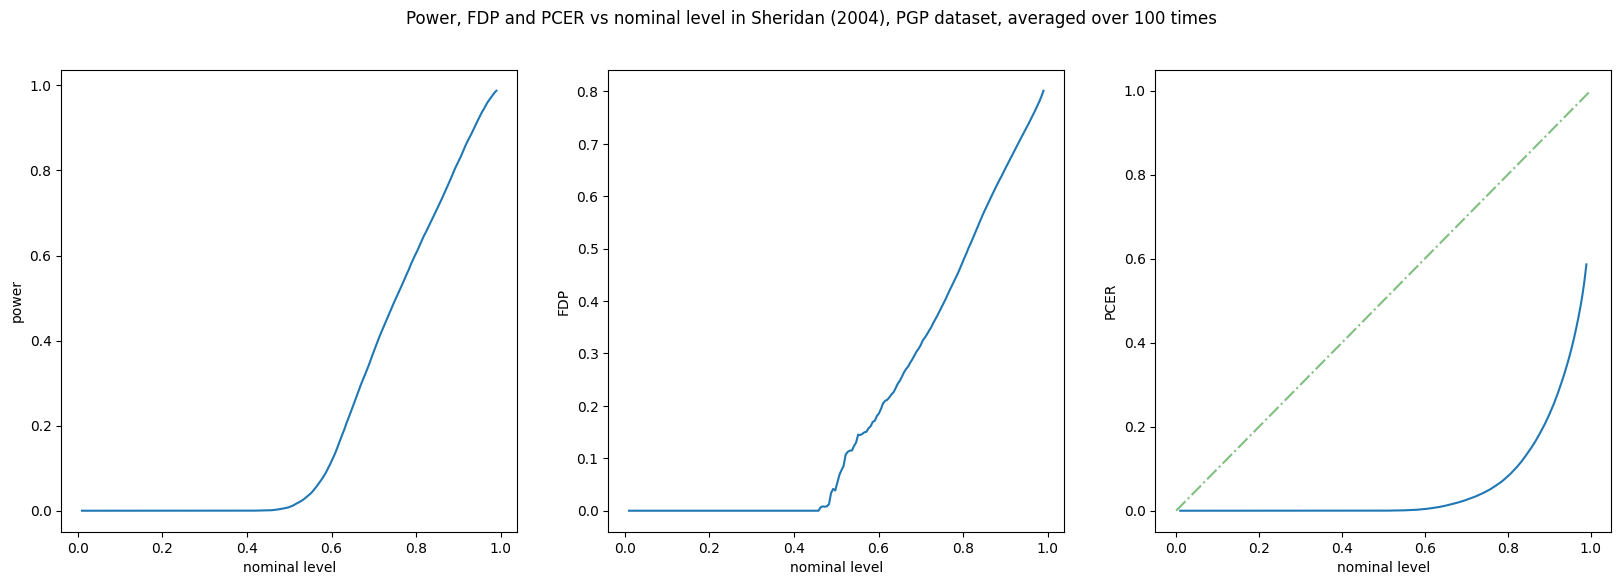

In [10]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 6))

fig.suptitle(f"Power, FDP and PCER vs nominal level in Sheridan (2004), {dataset_name} dataset, averaged over 100 times")
axs[0].plot(1 - alphas, powers_04)
axs[0].set_xlabel("nominal level")
axs[0].set_ylabel("power")
axs[1].plot(1 - alphas, fdps_04)
axs[1].set_xlabel("nominal level")
axs[1].set_ylabel("FDP")
axs[2].plot(1 - alphas, pcers_04)
axs[2].plot([0, 1], [0, 1], color='green', linestyle='-.', alpha=0.5)
axs[2].set_xlabel("nominal level")
axs[2].set_ylabel("PCER")
plt.show()

##### Sheridan (2012) 

In [11]:
# using 3 bin
rmse_test = []
for s, p, v in zip(sim_test, Ypred_test, var_test):
    # using an adaptive binsize
    dice_binsize = (RMSE_df["dice"].max() - RMSE_df["dice"].min()) / 20
    pred_binsize = (RMSE_df["pred"].max() - RMSE_df["pred"].min()) / 20
    var_binsize = (RMSE_df["var"].max() - RMSE_df["var"].min()) / 20
    filtered_RMSE_df = RMSE_df[(s - dice_binsize <= RMSE_df["dice"]) & (RMSE_df["dice"] <= s + dice_binsize) & 
                               (p - pred_binsize <= RMSE_df["pred"]) & (RMSE_df["pred"] <= p + pred_binsize) &
                               (v - var_binsize <= RMSE_df["var"]) & (RMSE_df["var"] <= v + var_binsize)]
    rmse = filtered_RMSE_df["RMSE"].mean()
    rmse_test.append(rmse)
rmse_test = np.array(rmse_test)

In [12]:
from scipy.stats import norm

# miscoverage: 0.01 to 0.5
misc = np.linspace(0.01, 0.99, 200)
alphas = 1 - misc  # confidence level

eps = [norm.ppf(alpha) for alpha in alphas] # positive
fdps_12, pcers_12, powers_12 = np.zeros(200), np.zeros(200), np.zeros(200)

itr = 100
for k in tqdm(range(itr)):
    # repartition data and fit
    rf = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt')
    Xtrain, Xcalib, Ytrain, Ycalib = train_test_split(Xtc, Ytc, train_size=0.3, shuffle=True)
    rf.fit(Xtrain, Ytrain)
    Ypred_test = rf.predict(Xtest)

    for i, ep in enumerate(eps):
        # build (-inf, Ypred + ep * rmse), alpha% confidence interval
        sheridan_12 = [j for j in range(len(Ypred_test)) if Ypred_test[j] + ep * rmse_test[j] <= threshold]
        fdp, pcer, power = eval(Ytest, sheridan_12, -100, threshold)
        fdps_12[i] += fdp / itr
        pcers_12[i] += pcer / itr
        powers_12[i] += power / itr

100%|██████████| 100/100 [01:35<00:00,  1.04it/s]


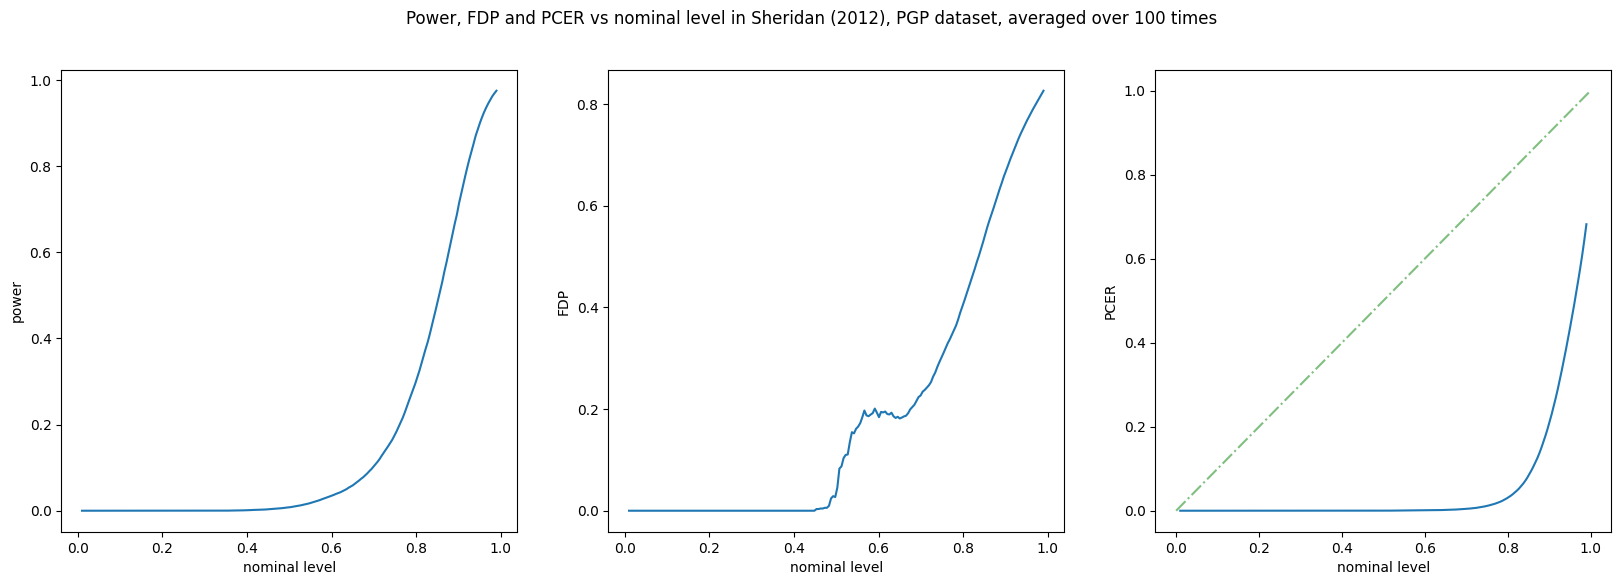

In [13]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 6))

fig.suptitle(f"Power, FDP and PCER vs nominal level in Sheridan (2012), {dataset_name} dataset, averaged over 100 times")
axs[0].plot(1 - alphas, powers_12)
axs[0].set_xlabel("nominal level")
axs[0].set_ylabel("power")
axs[1].plot(1 - alphas, fdps_12)
axs[1].set_xlabel("nominal level")
axs[1].set_ylabel("FDP")
axs[2].plot(1 - alphas, pcers_12)
axs[2].plot([0, 1], [0, 1], color='green', linestyle='-.', alpha=0.5)
axs[2].set_xlabel("nominal level")
axs[2].set_ylabel("PCER")
plt.show()

##### Sheridan et al. (eCounterScreening, 2015) with tree variance

In [12]:
# risk-benefit curve
from tqdm import tqdm

R_list = np.linspace(0.5, -4, 200)
benefit_list = np.zeros(200)
power_list = np.zeros(200)
fdp_list = np.zeros(200)

itr = 100

for k in tqdm(range(itr)):
    rf = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt')
    Xtrain, Xcalib, Ytrain, Ycalib = train_test_split(Xtc, Ytc, train_size=0.5, shuffle=True)
    rf.fit(Xtrain, Ytrain)
    Ypred_calib = rf.predict(Xcalib)
    all_Ypred = np.column_stack([tree.predict(Xcalib) for tree in rf.estimators_])
    var_calib = np.var(all_Ypred, axis=1)

    z_calib = (threshold - Ypred_calib) / var_calib

    for i, R in enumerate(R_list):
        try_r_sel = [j for j in range(len(z_calib)) if z_calib[j] >= R]
        try_fdp, _, try_power = eval(Ycalib, try_r_sel, -100, threshold)
        fdp_list[i] += try_fdp / itr
        benefit_list[i] += len(try_r_sel) / (len(Ycalib) * itr)
        power_list[i] += try_power / itr

100%|██████████| 100/100 [00:19<00:00,  5.05it/s]


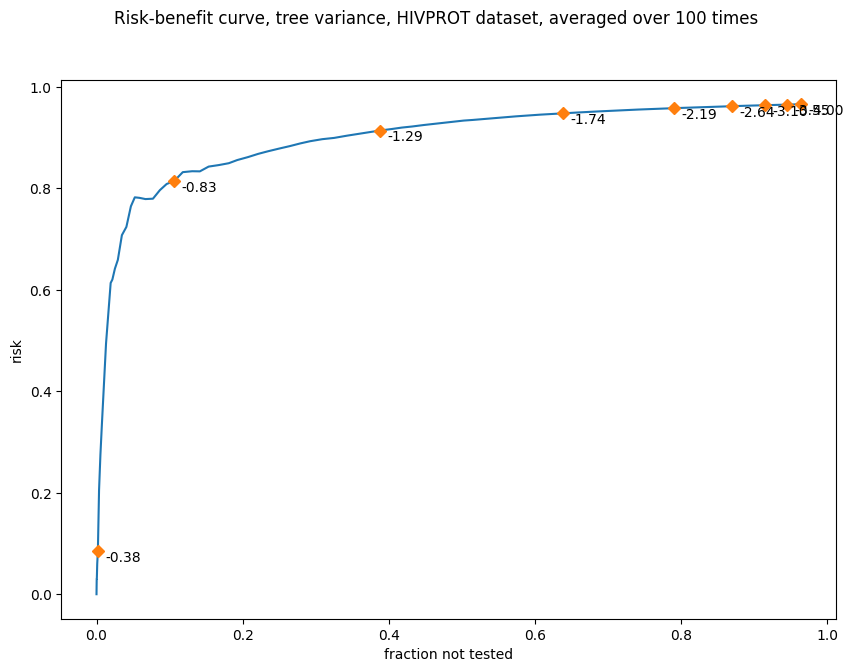

In [13]:
fig, axs = plt.subplots(figsize=(10, 7))
idx_list = [39, 59, 79, 99, 119, 139, 159, 179, 199]
axs.plot(benefit_list, fdp_list)
axs.plot(benefit_list[idx_list], fdp_list[idx_list], 'D')
axs.set_xlabel('fraction not tested')
axs.set_ylabel('risk')
for idx in idx_list:
    r = R_list[idx]
    axs.text(benefit_list[idx] + 0.01, fdp_list[idx] - 0.02, f'{r:.2f}')
fig.suptitle(f'Risk-benefit curve, tree variance, {dataset_name} dataset, averaged over {itr} times')
plt.show()

In [14]:
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

fdp_nominals = np.linspace(0.01, 0.99, 200)
fdps_15_tv, pcers_15_tv, powers_15_tv = np.zeros(200), np.zeros(200), np.zeros(200)

itr = 100

for k in tqdm(range(itr)):
    rf = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt')
    Xtrain, Xcalib, Ytrain, Ycalib = train_test_split(Xtc, Ytc, train_size=0.3, shuffle=True)
    rf.fit(Xtrain, Ytrain)

    R_list = np.zeros(200)
    Ypred_calib = rf.predict(Xcalib)
    all_Ypred = np.column_stack([tree.predict(Xcalib) for tree in rf.estimators_])
    var_calib = np.var(all_Ypred, axis=1)

    z_calib = (threshold - Ypred_calib) / var_calib
    
    for R in np.linspace(0.5, -4, 200):
        try_r_sel = [j for j in range(len(z_calib)) if z_calib[j] >= R]
        try_fdp, _, _ = eval(Ycalib, try_r_sel, -100, threshold)
        R_list[fdp_nominals >= try_fdp] = R

    # print(R_list)
        
    Ypred_test = rf.predict(Xtest)
    all_Ypred = np.column_stack([tree.predict(Xtest) for tree in rf.estimators_])
    var_test = np.var(all_Ypred, axis=1)
    
    z_test = (threshold - Ypred_test) / var_test

    # select everything with z >= ...
    for i, R in enumerate(R_list):
        sheridan_15 = [j for j in range(len(z_test)) if z_test[j] >= R]
        fdp, pcer, power = eval(Ytest, sheridan_15, -100, threshold)
        fdps_15_tv[i] += fdp / itr
        pcers_15_tv[i] += pcer / itr
        powers_15_tv[i] += power / itr

100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


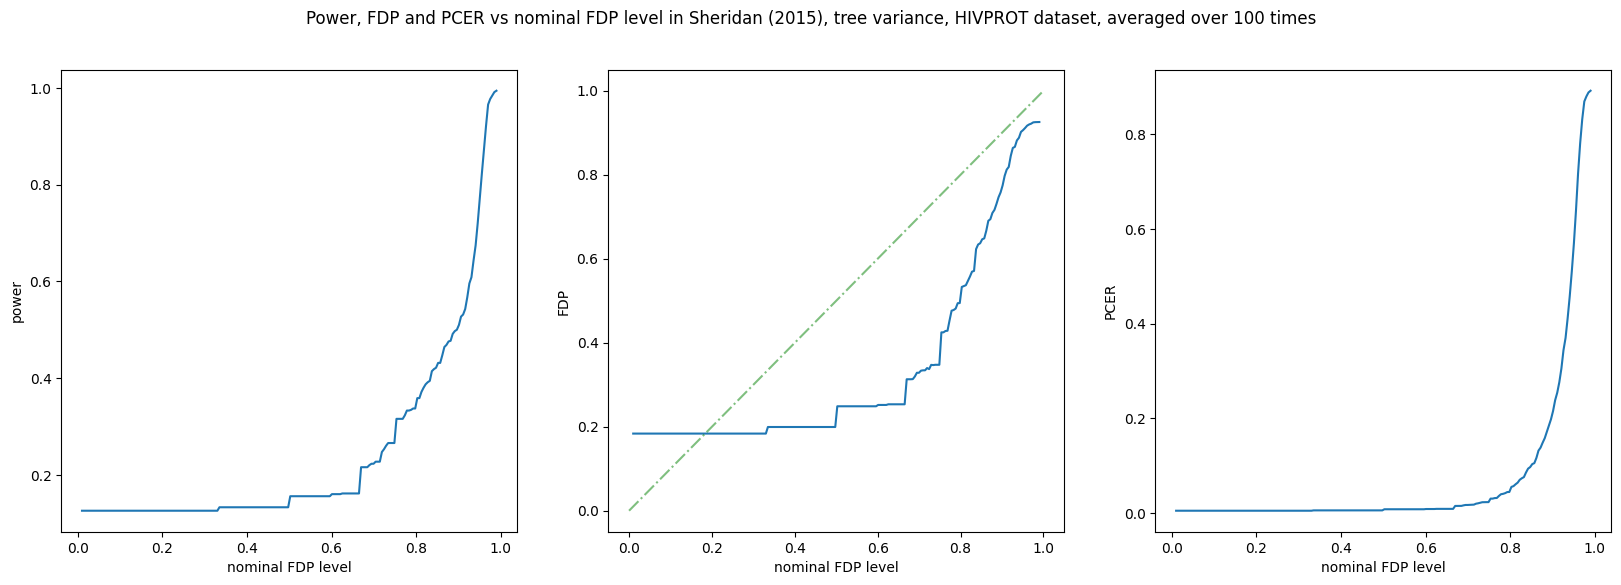

In [15]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 6))

fig.suptitle(f"Power, FDP and PCER vs nominal FDP level in Sheridan (2015), tree variance, {dataset_name} dataset, averaged over {itr} times")
axs[0].plot(fdp_nominals, powers_15_tv)
axs[0].set_xlabel("nominal FDP level")
axs[0].set_ylabel("power")
axs[1].plot(fdp_nominals, fdps_15_tv)
axs[1].set_xlabel("nominal FDP level")
axs[1].set_ylabel("FDP")
axs[2].plot(fdp_nominals, pcers_15_tv)
axs[1].plot([0, 1], [0, 1], color='green', linestyle='-.', alpha=0.5)
axs[2].set_xlabel("nominal FDP level")
axs[2].set_ylabel("PCER")
plt.show()

##### Sheridan et al. (eCounterScreening, 2015) with binned RMSE

In [ ]:
# despite originally used in deciding whether to test during counterscreening phase,
# sheridan's 2015 method could be briefly modified to decide what to select

# the selection procedure is simply to select all molecules with z score >= a certain threshold
# z = threshold - y_pred / uncertainty

# for the notion of prediction uncertainty, we could 
# 1. use the RMSE in the previous dataset 

In [18]:
# risk-benefit curve

R_list = np.linspace(0.5, -2, 200)
benefit_list = np.zeros(200)
power_list = np.zeros(200)
fdp_list = np.zeros(200)

itr = 10

for k in tqdm(range(itr)):
    rf = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt')
    Xtrain, Xcalib, Ytrain, Ycalib = train_test_split(Xtc, Ytc, train_size=0.5, shuffle=True)
    rf.fit(Xtrain, Ytrain)
    Ypred_calib = rf.predict(Xcalib)

    # slow
    sim_calib = np.array([dice_sim(x, Xtrain) for x in Xcalib])
    rmse_calib = []
    for s in sim_calib:
        filtered_RMSE_df = RMSE_df[(s - 0.05 <= RMSE_df["dice"]) & (RMSE_df["dice"] <= s + 0.05)]
        rmse = filtered_RMSE_df["RMSE"].mean()
        rmse_calib.append(rmse)
    rmse_calib = np.array(rmse_calib)

    z_calib = (threshold - Ypred_calib) / rmse_calib

    for i, R in enumerate(R_list):
        try_r_sel = [j for j in range(len(z_calib)) if z_calib[j] >= R]
        try_fdp, _, try_power = eval(Ycalib, try_r_sel, -100, threshold)
        fdp_list[i] += try_fdp / itr
        benefit_list[i] += len(try_r_sel) / (len(Ycalib) * itr)
        power_list[i] += try_power / itr

100%|██████████| 10/10 [07:51<00:00, 47.12s/it]


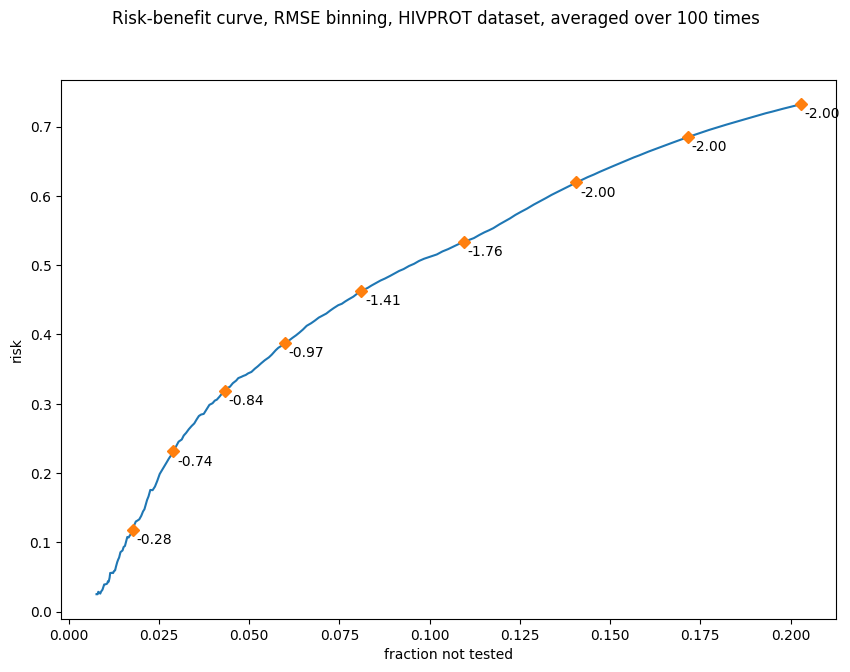

In [30]:
fig, axs = plt.subplots(figsize=(10, 7))
idx_list = [39, 59, 79, 99, 119, 139, 159, 179, 199]
axs.plot(benefit_list, fdp_list)
axs.plot(benefit_list[idx_list], fdp_list[idx_list], 'D')
axs.set_xlabel('fraction not tested')
axs.set_ylabel('risk')
for idx in idx_list:
    r = R_list[idx]
    axs.text(benefit_list[idx] + 0.001, fdp_list[idx] - 0.02, f'{r:.2f}')
fig.suptitle(f'Risk-benefit curve, RMSE binning, {dataset_name} dataset, averaged over {itr} times')
plt.show()

In [20]:
# using only 1 bin
rmse_test = []
for s in sim_test:
    # using a fixed 0.05 binsize
    filtered_RMSE_df = RMSE_df[(s - 0.05 <= RMSE_df["dice"]) & (RMSE_df["dice"] <= s + 0.05)]
    rmse = filtered_RMSE_df["RMSE"].mean()
    rmse_test.append(rmse)
rmse_test = np.array(rmse_test)

In [21]:
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

fdp_nominals = np.linspace(0.01, 0.99, 200)
fdps_15_rb, pcers_15_rb, powers_15_rb = np.zeros(200), np.zeros(200), np.zeros(200)

itr = 10

for k in tqdm(range(itr)):
    rf = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt')
    Xtrain, Xcalib, Ytrain, Ycalib = train_test_split(Xtc, Ytc, train_size=0.3, shuffle=True)
    rf.fit(Xtrain, Ytrain)
    Ypred_calib = rf.predict(Xcalib)
    
    # use Xcalib, Ycalib to decide the R threshold
    # search on the smallest R with corresponding FDP <= nominal FDP

    R_list = np.zeros(200)
    sim_calib = np.array([dice_sim(x, Xtrain) for x in Xcalib])
    rmse_calib = []
    for s in sim_calib:
        filtered_RMSE_df = RMSE_df[(s - 0.05 <= RMSE_df["dice"]) & (RMSE_df["dice"] <= s + 0.05)]
        rmse = filtered_RMSE_df["RMSE"].mean()
        rmse_calib.append(rmse)
    rmse_calib = np.array(rmse_calib)

    z_calib = (threshold - Ypred_calib) / rmse_calib
    
    for R in np.linspace(0.5, -2, 200):
        try_r_sel = [j for j in range(len(z_calib)) if z_calib[j] >= R]
        try_fdp, _, _ = eval(Ycalib, try_r_sel, -100, threshold)
        R_list[fdp_nominals >= try_fdp] = R

    # print(R_list)
        
    Ypred_test = rf.predict(Xtest)
    z_test = (threshold - Ypred_test) / rmse_test

    # select everything with z >= ...
    for i, R in enumerate(R_list):
        sheridan_15 = [j for j in range(len(z_test)) if z_test[j] >= R]
        fdp, pcer, power = eval(Ytest, sheridan_15, -100, threshold)
        fdps_15_rb[i] += fdp / itr
        pcers_15_rb[i] += pcer / itr
        powers_15_rb[i] += power / itr

100%|██████████| 10/10 [06:55<00:00, 41.58s/it]


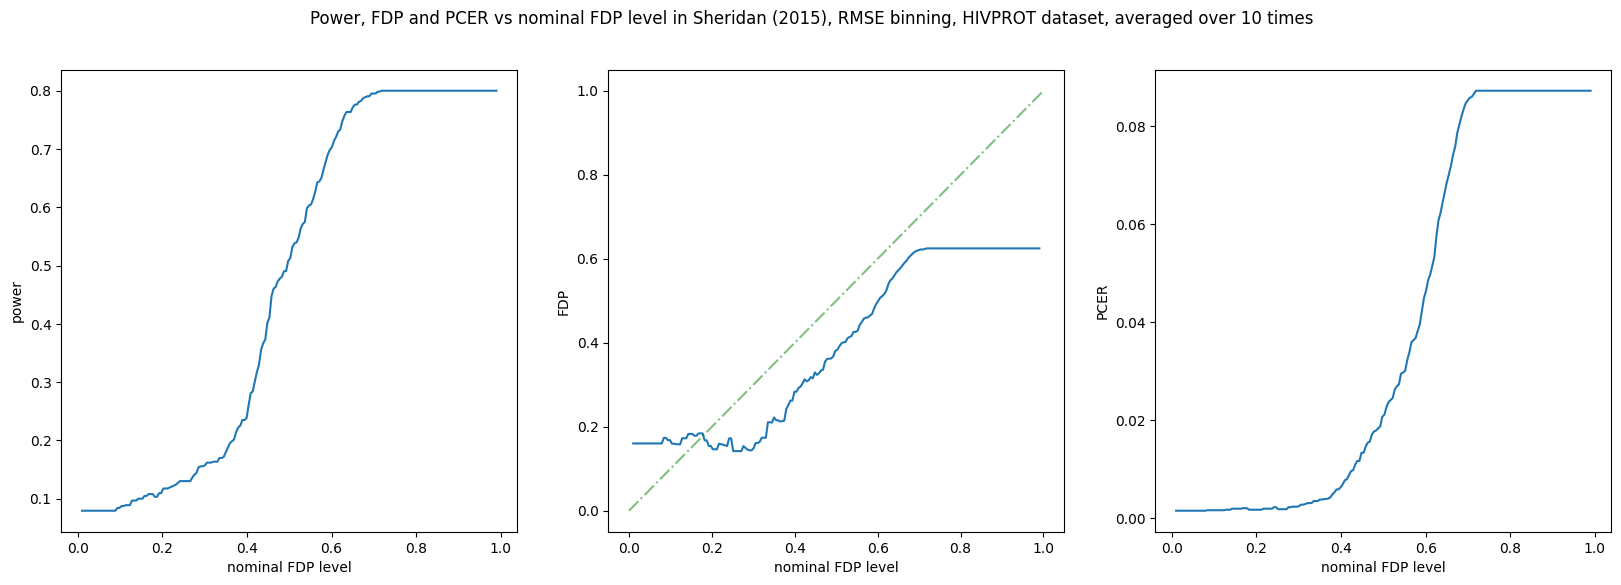

In [22]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 6))

fig.suptitle(f"Power, FDP and PCER vs nominal FDP level in Sheridan (2015), RMSE binning, {dataset_name} dataset, averaged over 10 times")
axs[0].plot(fdp_nominals, powers_15_rb)
axs[0].set_xlabel("nominal FDP level")
axs[0].set_ylabel("power")
axs[1].plot(fdp_nominals, fdps_15_rb)
axs[1].set_xlabel("nominal FDP level")
axs[1].set_ylabel("FDP")
axs[2].plot(fdp_nominals, pcers_15_rb)
axs[1].plot([0, 1], [0, 1], color='green', linestyle='-.', alpha=0.5)
axs[2].set_xlabel("nominal FDP level")
axs[2].set_ylabel("PCER")
plt.show()

##### Sheridan et al. (eCounterScreening, 2015) with RMSE predictor

In [23]:
# risk-benefit curve

R_list = np.linspace(0.5, -2, 200)
benefit_list = np.zeros(200)
power_list = np.zeros(200)
fdp_list = np.zeros(200)

itr = 100

for k in tqdm(range(itr)):
    rf = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt')
    Xtrain, Xcalib, Ytrain, Ycalib = train_test_split(Xtc, Ytc, train_size=0.7, shuffle=True)
    Xtrain, Xtrain_rmse, Ytrain, Ytrain_rmse = train_test_split(Xtc, Ytc, train_size=0.5, shuffle=True)
    rf.fit(Xtrain, Ytrain)

    rf_rmse = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt')
    rf_rmse.fit(Xtrain_rmse, np.abs(Ytrain_rmse - rf.predict(Xtrain_rmse)))

    Ypred_calib = rf.predict(Xcalib)
    rmse_calib = rf_rmse.predict(Xcalib)

    z_calib = (threshold - Ypred_calib) / rmse_calib

    for i, R in enumerate(R_list):
        try_r_sel = [j for j in range(len(z_calib)) if z_calib[j] >= R]
        try_fdp, _, try_power = eval(Ycalib, try_r_sel, -100, threshold)
        fdp_list[i] += try_fdp / itr
        benefit_list[i] += len(try_r_sel) / (len(Ycalib) * itr)
        power_list[i] += try_power / itr

100%|██████████| 100/100 [06:09<00:00,  3.70s/it]


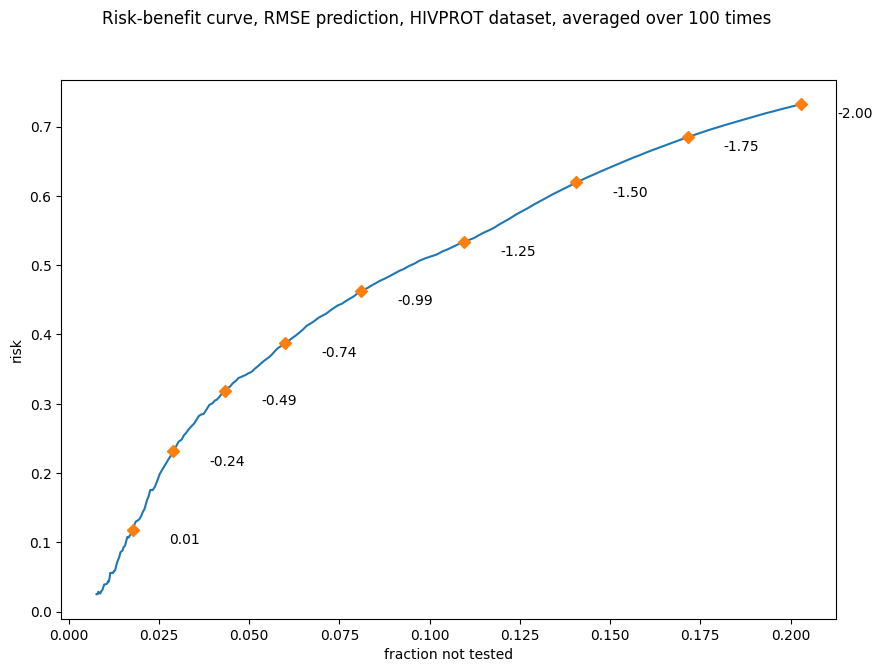

In [24]:
fig, axs = plt.subplots(figsize=(10, 7))
idx_list = [39, 59, 79, 99, 119, 139, 159, 179, 199]
axs.plot(benefit_list, fdp_list)
axs.plot(benefit_list[idx_list], fdp_list[idx_list], 'D')
axs.set_xlabel('fraction not tested')
axs.set_ylabel('risk')
for idx in idx_list:
    r = R_list[idx]
    axs.text(benefit_list[idx] + 0.01, fdp_list[idx] - 0.02, f'{r:.2f}')
fig.suptitle(f'Risk-benefit curve, RMSE prediction, {dataset_name} dataset, averaged over {itr} times')
plt.show()

In [25]:
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

fdp_nominals = np.linspace(0.01, 0.99, 200)
fdps_15_rp, pcers_15_rp, powers_15_rp = np.zeros(200), np.zeros(200), np.zeros(200)

itr = 100

for k in tqdm(range(itr)):
    rf = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt')
    rf_rmse = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt')
    Xtrain, Xcalib, Ytrain, Ycalib = train_test_split(Xtc, Ytc, train_size=0.3, shuffle=True)
    Xtrain, Xtrain_rmse, Ytrain, Ytrain_rmse = train_test_split(Xtrain, Ytrain, train_size=0.5, shuffle=True)
    rf.fit(Xtrain, Ytrain)
    rf_rmse.fit(Xtrain_rmse, np.abs(Ytrain_rmse - rf.predict(Xtrain_rmse)))
    
    Ypred_calib = rf.predict(Xcalib)
    rmse_calib = rf_rmse.predict(Xcalib)

    # use Xcalib, Ycalib to decide the R threshold
    # search on the smallest R with corresponding FDP <= nominal FDP

    R_list = np.zeros(200)
    z_calib = (threshold - Ypred_calib) / rmse_calib
    
    for R in np.linspace(0.5, -2, 200):
        try_r_sel = [j for j in range(len(z_calib)) if z_calib[j] >= R]
        try_fdp, _, _ = eval(Ycalib, try_r_sel, -100, threshold)
        R_list[fdp_nominals >= try_fdp] = R

    # print(R_list)
        
    Ypred_test = rf.predict(Xtest)
    rmse_test = rf_rmse.predict(Xtest)
    z_test = (threshold - Ypred_test) / rmse_test

    # select everything with z >= ...
    for i, R in enumerate(R_list):
        sheridan_15 = [j for j in range(len(z_test)) if z_test[j] >= R]
        fdp, pcer, power = eval(Ytest, sheridan_15, -100, threshold)
        fdps_15_rp[i] += fdp / itr
        pcers_15_rp[i] += pcer / itr
        powers_15_rp[i] += power / itr

100%|██████████| 100/100 [06:27<00:00,  3.88s/it]


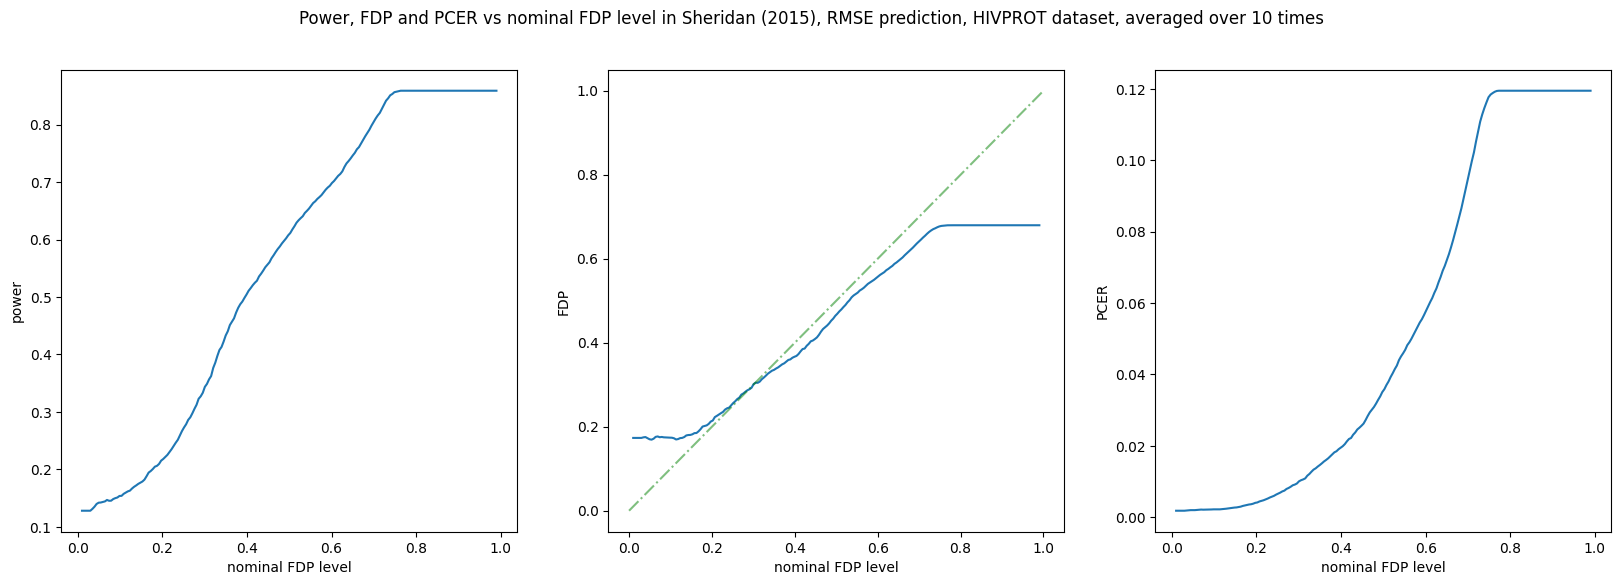

In [26]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 6))

fig.suptitle(f"Power, FDP and PCER vs nominal FDP level in Sheridan (2015), RMSE prediction, {dataset_name} dataset, averaged over 10 times")
axs[0].plot(fdp_nominals, powers_15_rp)
axs[0].set_xlabel("nominal FDP level")
axs[0].set_ylabel("power")
axs[1].plot(fdp_nominals, fdps_15_rp)
axs[1].set_xlabel("nominal FDP level")
axs[1].set_ylabel("FDP")
axs[2].plot(fdp_nominals, pcers_15_rp)
axs[1].plot([0, 1], [0, 1], color='green', linestyle='-.', alpha=0.5)
axs[2].set_xlabel("nominal FDP level")
axs[2].set_ylabel("PCER")
plt.show()

##### Conformal Selection

In [36]:
# Versus Conformal selection:
from utility import BH
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

fdp_nominals = np.linspace(0.01, 0.99, 200)
fdps_cs, pcers_cs, powers_cs = np.zeros(200), np.zeros(200), np.zeros(200)

itr = 10

for k in tqdm(range(itr)):
    rf = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt')
    Xtrain, Xcalib, Ytrain, Ycalib = train_test_split(Xtc, Ytc, train_size=0.7, shuffle=True)
    rf.fit(Xtrain, Ytrain < threshold)

    for i, fdp_nominal in enumerate(fdp_nominals):
        calib_scores_2clip = 1000 * (Ycalib < threshold) - rf.predict(Xcalib)   # Ycalib_cs > 0.5 <=> original Ycalib_cs < threshold
        test_scores = -rf.predict(Xtest)
        BH_2clip = BH(calib_scores_2clip, test_scores, fdp_nominal)
        fdp, pcer, power = eval(Ytest, BH_2clip, -100, threshold)
        fdps_cs[i] += fdp / itr
        pcers_cs[i] += pcer / itr
        powers_cs[i] += power / itr

100%|██████████| 10/10 [02:47<00:00, 16.77s/it]


In [35]:
len(Xtrain), len(Xcalib), len(Xtest)

(874, 2041, 1250)

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 6))

fig.suptitle(f"Power, FDP and PCER vs nominal level of conformal selection, {dataset_name} dataset, averaged over {itr} times")
axs[0].plot(fdp_nominals, powers_cs)
axs[0].set_xlabel("nominal level")
axs[0].set_ylabel("power")
axs[1].plot(fdp_nominals, fdps_cs)
axs[1].plot([0, 1], [0, 1], color='green', linestyle='-.', alpha=0.5)
axs[1].set_xlabel("nominal level")
axs[1].set_ylabel("FDP")
axs[2].plot(fdp_nominals, pcers_cs)
axs[2].set_xlabel("nominal level")
axs[2].set_ylabel("PCER")
plt.show()

In [33]:
from utility import BH
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

fdp_nominals = np.linspace(0.01, 0.99, 200)
fdps_cs, pcers_cs, powers_cs = np.zeros(200), np.zeros(200), np.zeros(200)

lower, higher = -100, threshold

train = pd.read_csv(dataset_path)

n = len(train)
perm = np.random.permutation(n)
test = train.iloc[perm[:int(0.3 * n)]]
calib = train.iloc[perm[int(0.3 * n):int(0.5 * n)]]
train = train.iloc[perm[int(0.5 * n):]]

Ytrain_cs, Ycalib_cs, Ytest_cs = train['Act'].to_numpy(), calib['Act'].to_numpy(), test['Act'].to_numpy()
Xtrain_cs, Xcalib_cs, Xtest_cs = train.drop(columns=['MOLECULE', 'Act']).to_numpy(), calib.drop(columns=['MOLECULE', 'Act']).to_numpy(), test.drop(columns=['MOLECULE', 'Act']).to_numpy()

Ytrain_cs_01 = 1 * ((lower < Ytrain_cs) & (Ytrain_cs < higher))
Ycalib_cs_01 = 1 * ((lower < Ycalib_cs) & (Ycalib_cs < higher))
Ytest_cs_01 = 1 * ((lower < Ytest_cs) & (Ytest_cs < higher))

itr = 10

for k in tqdm(range(itr)):
    rf = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt')
    rf.fit(Xtrain_cs, Ytrain_cs_01)

    for i, fdp_nominal in enumerate(fdp_nominals):
        calib_scores_2clip = 1000 * (Ycalib_cs_01 > 0) - rf.predict(Xcalib_cs)   # Ycalib_cs > 0.5 <=> original Ycalib_cs < threshold
        test_scores = -rf.predict(Xtest_cs)
        BH_2clip = BH(calib_scores_2clip, test_scores, fdp_nominal )
        fdp, pcer, power = eval(Ytest_cs, BH_2clip, -100, threshold)
        fdps_cs[i] += fdp / itr
        pcers_cs[i] += pcer / itr
        powers_cs[i] += power / itr

100%|██████████| 10/10 [02:26<00:00, 14.67s/it]


In [37]:
len(Xtrain_cs), len(Xcalib_cs), len(Xtest_cs)

(2083, 833, 1249)

##### Comparison

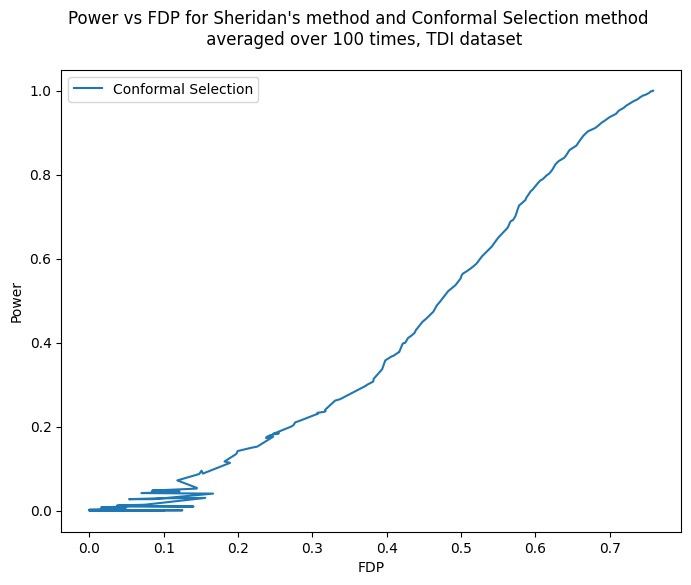

In [38]:
fig, axs = plt.subplots(figsize=(8, 6))

fig.suptitle(f"Power vs FDP for Sheridan's method and Conformal Selection method \n averaged over 100 times, {dataset_name} dataset")
# axs.plot(fdps_12, powers_12, label='Sheridan (2012)')
# axs.plot(fdps_04, powers_04, label='Sheridan (2004)')
# axs.plot(fdps_15_tv, powers_15_tv, label='Sheridan (2015), tv')
# axs.plot(fdps_15_rb, powers_15_rb, label='Sheridan (2015), rb')
# axs.plot(fdps_15_rp, powers_15_rp, label='Sheridan (2015), rp')
axs.plot(fdps_cs, powers_cs, label='Conformal Selection')
axs.set_xlabel("FDP")
axs.set_ylabel("Power")
plt.legend()
plt.show()